In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indoor-location-navigation/sample_submission.csv
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/B1/geojson_map.json
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/B1/floor_info.json
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/B1/floor_image.png
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/F3/geojson_map.json
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/F3/floor_info.json
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/F3/floor_image.png
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/F2/geojson_map.json
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/F2/floor_info.json
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/F2/floor_image.png
/kaggle/input/indoor-location-navigation/metadata/5cdbc652853bc856e89a8694/B1/geojson_ma

In [2]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import seaborn as sns # visualization

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

from tqdm import tqdm

import json
import plotly.graph_objs as go
from PIL import Image

from dataclasses import dataclass

In [3]:
!head -n 20  "../input/indoor-location-navigation/train/5a0546857ecc773753327266/F2/5dccf516c04f060006e6e3c9.txt"

In [4]:
@dataclass
class ReadData:
    acce:np.ndarray
    acce_uncali:np.ndarray
    gyro:np.ndarray
    gyro_uncali:np.ndarray
    magn:np.ndarray
    magn_uncali:np.ndarray
    ahrs:np.ndarray
    wifi:np.ndarray
    ibeacon:np.ndarray
    waypoint:np.ndarray
    

In [5]:
def read_data_file(file_name):
    acce=[]
    acce_uncali=[]
    gyro=[]
    gyro_uncali=[]
    magn=[]
    magn_uncali=[]
    ahrs=[]
    wifi=[]
    ibeacon=[]
    waypoint=[]
    
    with open(file_name,'r',encoding='utf-8') as file:
        lines = file.readlines()
    
    for line_data in lines:
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue
            
        line_data = line_data.split('\t')
        if(line_data[1] == 'TYPE_WAYPOINT'):
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])
            continue
        
        if(line_data[1] == 'TYPE_ACCELEROMETER'):
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue
            
        if(line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED'):
            acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue
        
        if(line_data[1] == 'TYPE_GYROSCOPE'):
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue
            
        if(line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED'):
            gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue
        
        if(line_data[1] == 'TYPE_MAGNETIC_FIELD'):
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue
            
        if(line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED'):
            magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue
            
        if(line_data[1] == 'TYPE_ROTATION_VECTOR'):
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue
            
        if(line_data[1] == 'TYPE_WIFI'):
            sys_ts = line_data[0]
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)
            continue
            
        if(line_data[1] == 'TYPE_BEACON'):
            ts = line_data[0]
            uuid = line_data[2]
            major  = line_data[3]
            minor = line_data[4]
            rssi =  line_data[6]
            beacon_data = [ts, '_'.join([uuid,major,minor]), rssi]
            ibeacon.append(beacon_data)
            continue
            
    acce = np.array(acce)
    acce_uncali = np.array(acce_uncali)
    gyro = np.array(gyro)
    gyro_uncali = np.array(gyro_uncali)
    magn = np.array(magn)
    magn_uncali = np.array(magn_uncali)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)
    
    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)
        
        
        

In [6]:
sample_file = read_data_file("../input/indoor-location-navigation/train/5a0546857ecc773753327266/F2/5dccf516c04f060006e6e3c9.txt")

print('acce shape:', sample_file.acce.shape)
print('acce_uncali shape:', sample_file.acce_uncali.shape)
print('gyro shape:', sample_file.gyro.shape)
print('gyro_uncali shape:', sample_file.gyro_uncali.shape)
print('magn shape:', sample_file.magn.shape)
print('magn_uncali shape:',sample_file.magn_uncali.shape)
print('ahrs shape:', sample_file.ahrs.shape)
print('wifi shape:', sample_file.wifi.shape)
print('ibeacon shape:', sample_file.ibeacon.shape)
print('waypoint shape:', sample_file.waypoint.shape)

acce shape: (1743, 4)
acce_uncali shape: (1743, 4)
gyro shape: (1743, 4)
gyro_uncali shape: (1743, 4)
magn shape: (1743, 4)
magn_uncali shape: (1743, 4)
ahrs shape: (1743, 4)
wifi shape: (5258, 5)
ibeacon shape: (267, 3)
waypoint shape: (6, 3)


In [7]:
from datetime import datetime
start_time = 1573713056850
end_time = 1573713091483

print(datetime.fromtimestamp(start_time/1000.0))
print(datetime.fromtimestamp(end_time/1000.0))
print(datetime.fromtimestamp(end_time/1000.0) - datetime.fromtimestamp(start_time/1000.0))

2019-11-14 06:30:56.850000
2019-11-14 06:31:31.483000
0:00:34.633000


In [8]:
waypoint_df = pd.DataFrame(sample_file.waypoint,columns = ['timestamp','waypoint_x','waypoint_y'])
display(waypoint_df.style.set_caption('Waypoint'))
# waypoint_df.head()

100%|██████████| 6/6 [00:00<00:00, 1783.80it/s]



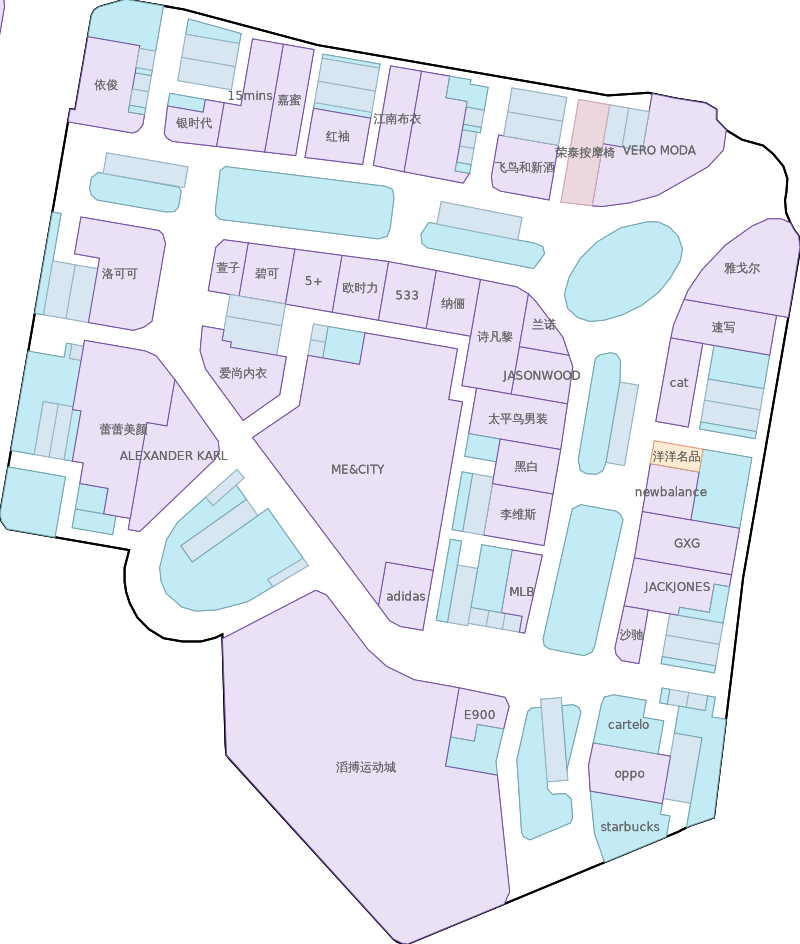

In [9]:
def visualize_trajectory(trajectory, floor_plan_filename, width_meter, height_meter, title=None, mode='lines+markers+text', show=False):
    fig = go.Figure()
    
    #add trajectory
    size_list = [6]*trajectory.shape[0]
    size_list[0] = 10
    size_list[-1] = 10
    
    color_list = ['rgba(4, 174, 4, 0.5)']*trajectory.shape[0]
    color_list[0] = 'rgba(12, 5, 235, 1)'
    color_list[-1] = 'rgba(235, 5, 5, 1)'
    
    position_count = {}
    text_list = []
    for i in tqdm(range(trajectory.shape[0])):
        if str(trajectory[i]) in position_count:
            position_count[str(trajectory[i])] += 1
        else:
            position_count[str(trajectory[i])] = 0
        
        text_list.append(''*position_count[str(trajectory[i])] + f'{i}')
    text_list[0] = 'Start 0'
    text_list[-1] = f'End {trajectory.shape[0] - 1}'
    fig.add_trace(
            go.Scattergl(
                x=trajectory[:, 0],
                y=trajectory[:, 1],
                mode=mode,
                marker=dict(size=size_list, color=color_list),
                line=dict(shape='linear', color='lightgrey', width=3, dash='dash'),
                text=text_list,
                textposition="top center",
                name='trajectory',
            ))  
    
    # add floor plan
    floor_plan = Image.open(floor_plan_filename)
    fig.update_layout(images=[
        go.layout.Image(
            source=floor_plan,
            xref="x",
            yref="y",
            x=0,
            y=height_meter,
            sizex=width_meter,
            sizey=height_meter,
            sizing="contain",
            opacity=1,
            layer="below",
        )
    ])
    # configure
    fig.update_xaxes(autorange=False, range=[0, width_meter])
    fig.update_yaxes(autorange=False, range=[0, height_meter], scaleanchor="x", scaleratio=1)
    fig.update_layout(
        title=go.layout.Title(
            text=title or "No title.",
            xref="paper",
            x=0,
        ),
        autosize=True,
        width=800,
        height=  800 * height_meter / width_meter,
        template="plotly_white",
    )

    if show:
        fig.show()

    return fig

def visualize_train_trajectory(path):
    """
    Edited from 
    https://www.kaggle.com/ihelon/indoor-location-exploratory-data-analysis
    """
    _id, floor = path.split("/")[:2]
    
    train_floor_data = read_data_file(f"../input/indoor-location-navigation/train/{path}")
    with open(f"../input/indoor-location-navigation/metadata/{_id}/{floor}/floor_info.json") as f:
        train_floor_info = json.load(f)

    return visualize_trajectory(
        train_floor_data.waypoint[:, 1:3], 
        f"../input/indoor-location-navigation/metadata/{_id}/{floor}/floor_image.png",
        train_floor_info["map_info"]["width"], 
        train_floor_info["map_info"]["height"],
        f"Visualization of {path}"
    )

visualize_train_trajectory("5a0546857ecc773753327266/F2/5dccf516c04f060006e6e3c9.txt")

In [10]:
temp = np.concatenate([sample_file.acce,
                      sample_file.acce_uncali[:,1:],
                      sample_file.gyro[:,1:],
                      sample_file.gyro_uncali[:,1:],
                      sample_file.magn[:,1:],
                      sample_file.magn_uncali[:,1:],
                      sample_file.ahrs[:,1:]], axis=1)

imu_df = pd.DataFrame(temp,columns=['timestamp', 'acce_x','acce_y', 'acce_z','acce_uncali_x','acce_uncali_y', 'acce_uncali_z',
              'gyro_x','gyro_y', 'gyro_z','gyro_uncali_x','gyro_uncali_y', 'gyro_uncali_z',
              'magn_x','magn_y', 'magn_z','magn_uncali_x','magn_uncali_y', 'magn_uncali_z',
              'ahrs_x','ahrs_y', 'ahrs_z'])

display(imu_df.head(5).style.set_caption('IMU Data'))

In [11]:
def plot_imu_signals(data,col,uncali=True):
    fig,ax = plt.subplots(nrows=3,ncols=1,figsize=(14,9))
    ax[0].set_ylabel(f'{col}_x')
    ax[1].set_ylabel(f'{col}_y')
    ax[2].set_ylabel(f'{col}_z')
    if uncali:
        sns.lineplot(x=data.timestamp, y=data[f'{col}_uncali_x'],
                    ax=ax[0], label='uncali', color='orange')
        sns.lineplot(x=data.timestamp, y=data[f'{col}_uncali_y'],
                    ax=ax[1], label='uncali', color='orange')
        sns.lineplot(x=data.timestamp, y=data[f'{col}_uncali_z'],
                    ax=ax[2], label='uncali', color='orange')
        
    sns.lineplot(x=data.timestamp, y=data[f'{col}_x'],
                    ax=ax[0], label='cali', color='blue')
    sns.lineplot(x=data.timestamp, y=data[f'{col}_y'],
                    ax=ax[1], label='cali', color='blue')
    sns.lineplot(x=data.timestamp, y=data[f'{col}_z'],
                    ax=ax[2], label='cali', color='blue')
    
    start_time = data.timestamp.min()
    end_time = data.timestamp.max()
    for i in range(3):
        ax[i].set_xlim([start_time,end_time])
    plt.tight_layout()
    plt.show()

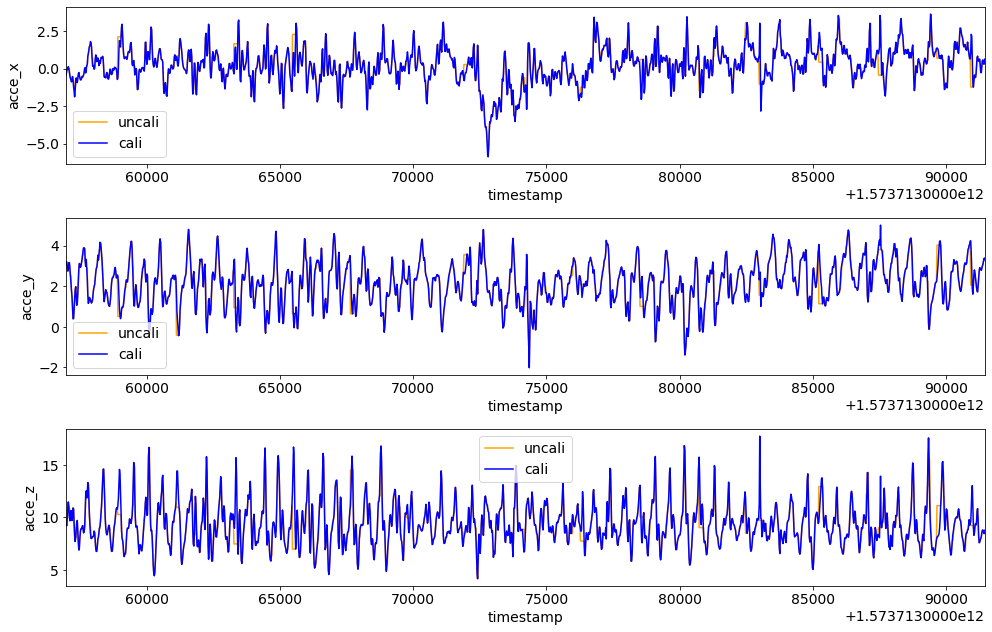

In [12]:
plot_imu_signals(imu_df,'acce')

In [13]:
def cal_from_pos(timestamp,pos):
    df = pd.DataFrame({'Timestamp': timestamp, 'Position': pos})
    df['Timestamp_ms'] = df['Timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000.0))
    df['Timedelta_ms'] = df['Timestamp_ms'].diff()
    df['Timedelta_s'] = df['Timedelta_ms'].apply(lambda x: x.total_seconds()).fillna(0)
    df['Velocity'] = ((df['Position'].diff())/df['Timedelta_s']).fillna(0)
    df['Acceleration'] = ((df['Velocity']).diff()/df['Timedelta_s']).fillna(0)
    
    return(df[['Timestamp', 'Timestamp_ms', 'Timedelta_s', 'Position', 'Velocity', 'Acceleration']])

In [14]:
def cal_from_acce(timestamp, acce, p_0):
    df = pd.DataFrame({'Timestamp':timestamp, 'Acceleration':acce})
    df['Timestamp_ms'] = df['Timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000.0))
    df['Timedelta_ms'] = df['Timestamp_ms'].diff()
    df['Timedelta_s'] = df['Timedelta_ms'].apply(lambda x: x.total_seconds()).fillna(0)
    df['Velocity'] = (df['Acceleration']*df['Timedelta_s']).cumsum()
    df['Position'] = p_0 + (df['Velocity']*df['Timedelta_s']).cumsum()
    
    return df[['Timestamp', 'Timestamp_ms', 'Timedelta_s', 'Position', 'Velocity', 'Acceleration']]

In [15]:
a_df = cal_from_acce(pd.Series([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]) * 1000 + start_time, 
               pd.Series([0, 0, 1.2, 1.2, 1.2, 0, 0, 0, -1.2, -1.2, -1.2, 0, 0]), -6)
display(a_df.style.set_caption('Calculated Position and Velocity from Acceleration'))

b_df = cal_from_pos(a_df.Timestamp, a_df.Position)
display(b_df.style.set_caption('Calculated Acceleration and Velocity from Position'))

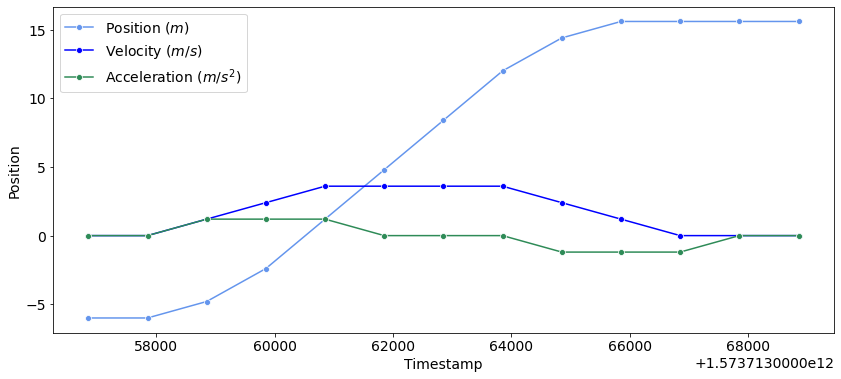

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
sns.lineplot(x=a_df.Timestamp, y=a_df.Position, ax=ax, color='cornflowerblue', marker='o', label='Position ($m$)')
sns.lineplot(x=a_df.Timestamp, y=a_df.Velocity, ax=ax, color='blue', marker='o', label='Velocity ($m/s$)')
sns.lineplot(x=a_df.Timestamp, y=a_df.Acceleration, ax=ax, color='seagreen', marker='o', label='Acceleration ($m/s^2$)')

plt.show()

In [17]:
imu_df_temp = cal_from_acce(imu_df.timestamp, 
                      (-1)*imu_df.acce_x, 
                      waypoint_df.waypoint_x.iloc[0])

display(imu_df_temp.head(5).style.set_caption('Calculated Position and Velocity from acce_x'))

waypoint_df_temp = cal_from_pos(waypoint_df.timestamp, waypoint_df.waypoint_x)
display(waypoint_df_temp.style.set_caption('Calculated Acceleration and Velocity from waypoint_x'))




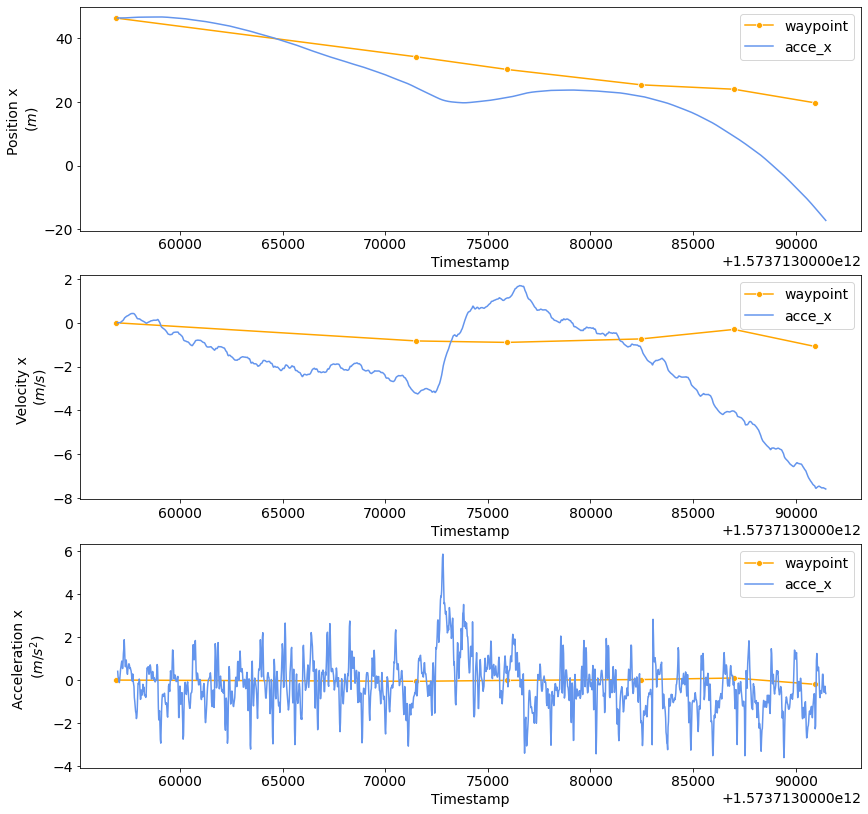

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14, 14))

sns.lineplot(x=waypoint_df_temp.Timestamp, y=waypoint_df_temp.Position, ax=ax[0], color='orange', marker='o', label='waypoint')
sns.lineplot(x=imu_df_temp.Timestamp, y=imu_df_temp.Position, ax=ax[0], color='cornflowerblue', label='acce_x')
ax[0].set_ylabel('Position x \n($m$)')

sns.lineplot(x=waypoint_df_temp.Timestamp, y=waypoint_df_temp.Velocity, ax=ax[1], color='orange', marker='o', label='waypoint')
sns.lineplot(x=imu_df_temp.Timestamp, y=imu_df_temp.Velocity, ax=ax[1], color='cornflowerblue', label='acce_x')
ax[1].set_ylabel('Velocity x \n($m/s$)')

sns.lineplot(x=waypoint_df_temp.Timestamp, y=waypoint_df_temp.Acceleration, ax=ax[2], color='orange', marker='o', label='waypoint')
sns.lineplot(x=imu_df_temp.Timestamp, y=imu_df_temp.Acceleration, ax=ax[2], color='cornflowerblue', label='acce_x')
ax[2].set_ylabel('Acceleration x \n($m/s^2$)')

plt.show()

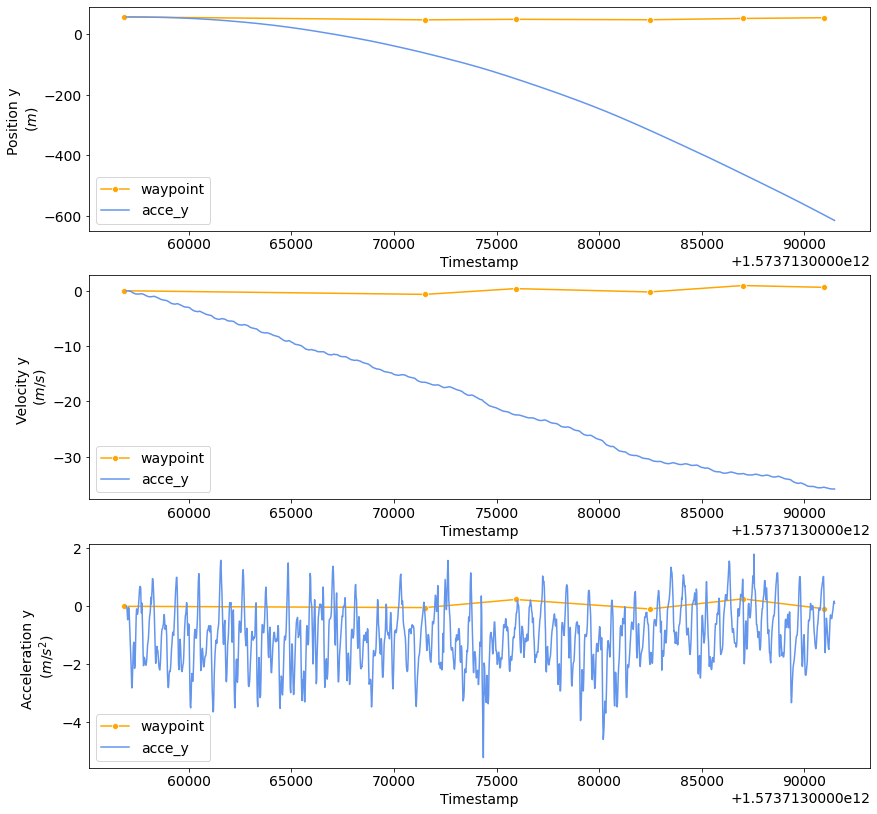

In [19]:
imu_df_temp = cal_from_acce(imu_df.timestamp, 
                      imu_df.acce_y - 3.208404, 
                      waypoint_df.waypoint_y.iloc[0])

display(imu_df_temp.head(5).style.set_caption('Calculated Position and Velocity from acce_y'))

waypoint_df_temp = cal_from_pos(waypoint_df.timestamp, waypoint_df.waypoint_y)
display(waypoint_df_temp.style.set_caption('Calculated Acceleration and Velocity from waypoint_y'))


fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14, 14))

sns.lineplot(x=waypoint_df_temp.Timestamp, y=waypoint_df_temp.Position, ax=ax[0], color='orange', marker='o', label='waypoint')
sns.lineplot(x=imu_df_temp.Timestamp, y=imu_df_temp.Position, ax=ax[0], color='cornflowerblue', label='acce_y')
ax[0].set_ylabel('Position y \n($m$)')

sns.lineplot(x=waypoint_df_temp.Timestamp, y=waypoint_df_temp.Velocity, ax=ax[1], color='orange', marker='o', label='waypoint')
sns.lineplot(x=imu_df_temp.Timestamp, y=imu_df_temp.Velocity, ax=ax[1], color='cornflowerblue', label='acce_y')
ax[1].set_ylabel('Velocity y \n($m/s$)')

sns.lineplot(x=waypoint_df_temp.Timestamp, y=waypoint_df_temp.Acceleration, ax=ax[2], color='orange', marker='o', label='waypoint')
sns.lineplot(x=imu_df_temp.Timestamp, y=imu_df_temp.Acceleration, ax=ax[2], color='cornflowerblue', label='acce_y')
ax[2].set_ylabel('Acceleration y \n($m/s^2$)')

plt.show()

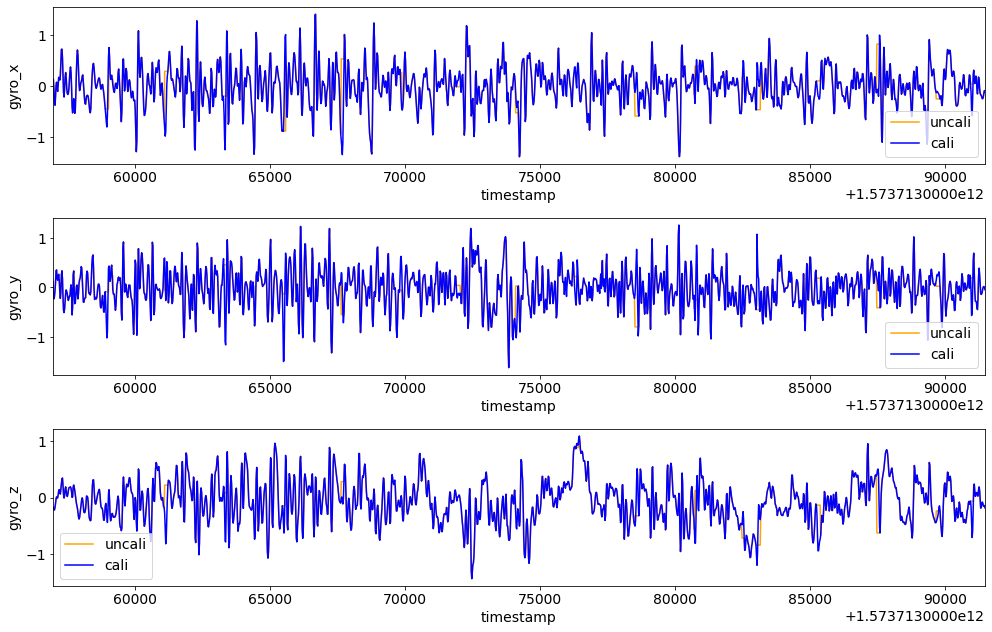

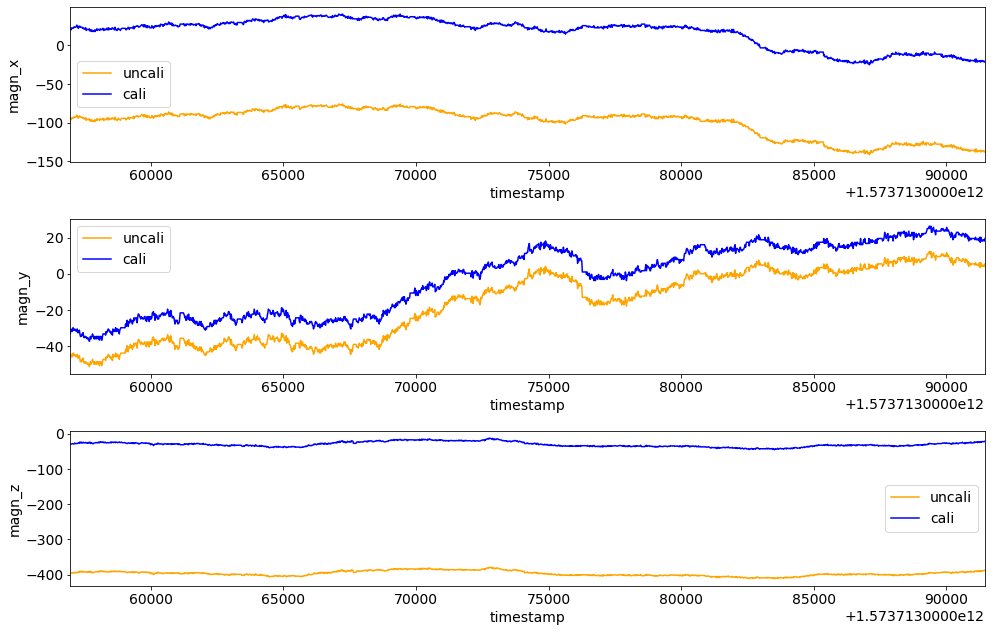

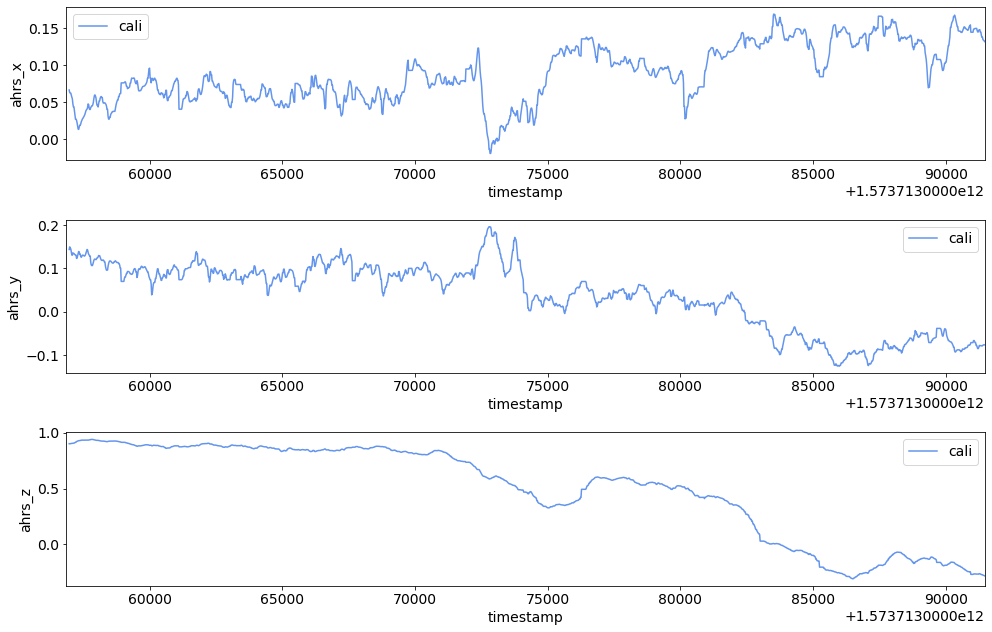

In [20]:
plot_imu_signals(imu_df,'gyro')
plot_imu_signals(imu_df,'magn')

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14, 9))
col = 'ahrs'
sns.lineplot(x=imu_df.timestamp, y=imu_df[f"{col}_x"], ax=ax[0], label='cali', color='cornflowerblue')
sns.lineplot(x=imu_df.timestamp, y=imu_df[f"{col}_y"], ax=ax[1], label='cali', color='cornflowerblue')
sns.lineplot(x=imu_df.timestamp, y=imu_df[f"{col}_z"], ax=ax[2], label='cali', color='cornflowerblue')
for i in range(3):
    ax[i].set_xlim([start_time, end_time])

plt.tight_layout()
plt.show()

In [21]:
wifi_df = pd.DataFrame(sample_file.wifi, columns=['timestamp', 'ssid', 'bssid', 'rssi', 'last_seen_timestamp'])
wifi_df.head()

timestamp                                      ssid  \
0  1573713058949  2bd871cb979cd9448e2c14df9ccdc1a003b615af   
1  1573713058949  bb17fdb81a16e158502f7df2335c33e76fdf6df9   
2  1573713058949  da39a3ee5e6b4b0d3255bfef95601890afd80709   
3  1573713058949  da39a3ee5e6b4b0d3255bfef95601890afd80709   
4  1573713058949  da39a3ee5e6b4b0d3255bfef95601890afd80709   

                                      bssid rssi last_seen_timestamp  
0  7c572eddccf9b8d9a97e7b1e1c9aa5e0831bb008  -42       1573713057117  
1  6d22a28a88b235942084f24966d6cf59032c2d8e  -49       1573713054395  
2  296ea9e41acd823ca04a211edefa7cc6457728a4  -51       1573713043813  
3  fd83a61cb82476f0ad6af28c4cd5872f285fd104  -52       1573713041473  
4  b550acc32dcc2b1726425312c5bfe19805047b39  -53       1573713043320

In [22]:
wifi_df = wifi_df.pivot(index='timestamp', columns=['ssid', 'bssid'])['rssi']
wifi_df.reset_index(drop=False, inplace=True)
wifi_df.style.set_caption('WiFi')

8it [00:00, 42.30it/s]


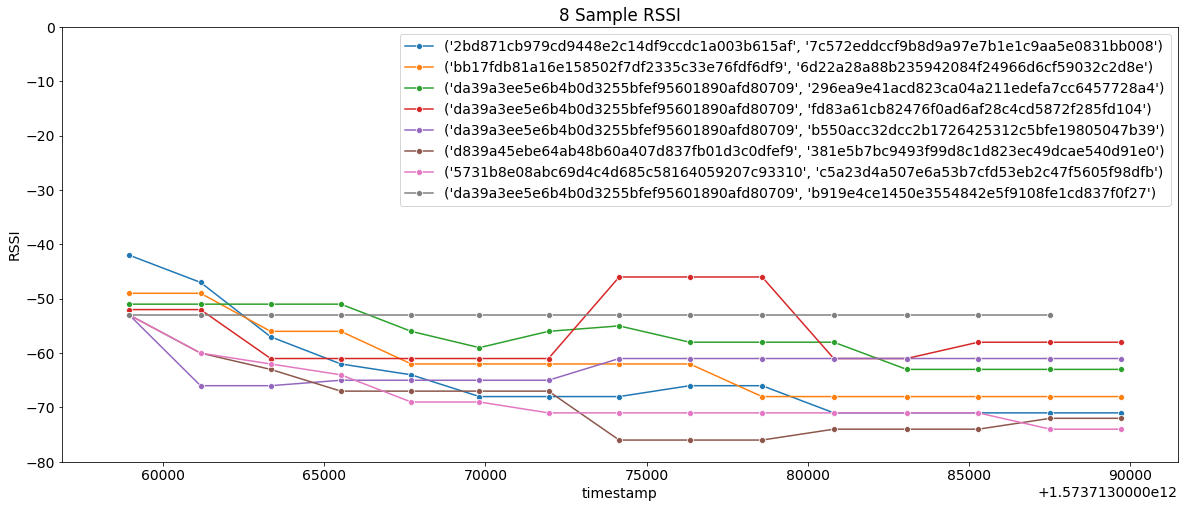

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,8))

for i,c in tqdm(enumerate(wifi_df.columns)):
    if c != ('timestamp',''):
        sns.lineplot(x=wifi_df.timestamp.astype(int),
                    y=wifi_df[c].replace('NaN',np.nan).astype(float),
                    ax=ax, marker='o', label=c)
    if i == 8:
        break
        
ax.set_xlim([start_time, end_time])
ax.set_ylim([-80, 0])

ax.set_ylabel('RSSI')
ax.set_title('8 Sample RSSI')
plt.show()